In [1]:
import sys
import logging
from optparse import OptionParser
from time import time
from datetime import datetime
from tqdm import tqdm
import json

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.ensemble import GradientBoostingRegressor
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import psycopg2

/home/mc/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Step 1) Define database information and connection

In [2]:
username = 'postgres'
password = 'jlmlcook'
host     = 'localhost'
port     = '5432'
db_name  = 'etsy'

con = None
con = psycopg2.connect(user = username, password = password, host = host, port = port, database = db_name)

Step 2) Get the relevant listings you want and put them into a Pandas dataframe

In [3]:
#Get relevant listing ids
sql_query = None
sql_query = """
SELECT DISTINCT listings.listing_id
FROM listings
FULL JOIN categories ON listings.listing_id=categories.listing_id
WHERE category = 'Hat' OR category = 'Hats'
"""

id_list = pd.read_sql_query(sql_query,con)['listing_id'].tolist()

In [4]:
column_names = ['listing_id','price','currency_code','views','num_favorers','original_creation_tsz','ending_tsz']

listings = []
tags = []
categories = []
materials = []
styles = []

with tqdm(total=len(id_list), file=sys.stdout) as pbar:
    #id_list = [100000914]
    for i, listing_id in enumerate(id_list):
        pbar.set_description('processed: %d' % (1 + i))
        pbar.update(1)
        # Get listing table info for this ID
        sql_query = str('SELECT * FROM listings WHERE listings.listing_id='+str(listing_id))
        listings.append(pd.read_sql_query(sql_query,con)[column_names].copy(deep=True))       
        #listing = pd.read_sql_query(sql_query,con)[column_names].copy(deep=True)
    
        # Get tags table info for this ID
        sql_query = str('SELECT * FROM tags WHERE tags.listing_id='+str(listing_id))
        tags.append(" ".join(pd.read_sql_query(sql_query,con)['tag']).lower())
        #tags = list(set(" ".join(pd.read_sql_query(sql_query,con)['tag'].tolist()).lower().split()))
    
        # Get categories table info for this ID
        sql_query = str('SELECT * FROM categories WHERE categories.listing_id='+str(listing_id))
        categories.append(" ".join(pd.read_sql_query(sql_query,con)['category']).lower())
        #categories = list(set(" ".join(pd.read_sql_query(sql_query,con)['category'].tolist()).lower().split()))
    
        # Get materials table info for this ID
        sql_query = str('SELECT * FROM materials WHERE materials.listing_id='+str(listing_id))
        materials.append(" ".join(pd.read_sql_query(sql_query,con)['material']).lower())
        #materials = list(set(" ".join(pd.read_sql_query(sql_query,con)['material'].tolist()).lower().split()))
    
        # Get styles table info for this ID
        sql_query = str('SELECT * FROM styles WHERE styles.listing_id='+str(listing_id))
        styles.append(" ".join(pd.read_sql_query(sql_query,con)['style']).lower())
        #styles = list(set(" ".join(pd.read_sql_query(sql_query,con)['style'].tolist()).lower().split()))

listings = pd.concat(listings, ignore_index=True)

processed: 36570: 100%|██████████| 36570/36570 [06:24<00:00, 95.11it/s]


Step 3) First step of data cleaning and processing

In [5]:
# Combine all features into a list of lists
all_features = []
for i in range(len(tags)):
    all_features.append(tags[i]+" "+materials[i]+" "+styles[i])

# Change number of views and favorers to views/flavorers per week
start = listings['original_creation_tsz'].tolist()
end = listings['ending_tsz'].tolist()
d_start = [datetime.strptime(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'), "%Y-%m-%d %H:%M:%S") for i, x in enumerate(start)]
d_end = [datetime.strptime(datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'), "%Y-%m-%d %H:%M:%S") for i, x in enumerate(end)]
difference = [(d_end[i] - d_start[i]).days for i in range(len(d_start))]
listings = listings.assign(days=pd.Series(difference))
views = listings['views'].tolist()
num_favorers = listings['num_favorers'].tolist()
days = listings['days'].tolist()
views_week = [(views[i] / days[i]) * 7.0 for i in range(len(views))]
num_favorers_week = [(num_favorers[i] / days[i]) * 7.0 for i in range(len(num_favorers))]
listings = listings.assign(views=pd.Series(views_week))
listings = listings.assign(num_favorers=pd.Series(num_favorers_week))

In [6]:
# Save cleaned and processed data to pickle files
joblib.dump(listings, 'listings.pkl')
joblib.dump(all_features, 'all_features.pkl')

['all_features.pkl']

Step 4) Data pipeline - Create Vectorizers

In [7]:
# Extract features with sparse vectorizers
n_features = 500 # Number of features
n_samples = len(all_features) # Number of samples
n_components = 50 # Number of components
n_top_words = 10  # Number of top words

In [8]:
# Hashing vectorizer
# Perform an IDF normalization on the output of HashingVectorizer
hasher = HashingVectorizer(n_features=n_features,
                           stop_words='english', alternate_sign=False,
                           norm=None, binary=False)
hash_vectorizer = make_pipeline(hasher, TfidfTransformer())
t0 = time()
hash_vectorized_features = hash_vectorizer.fit_transform(all_features)
print("done in %0.3fs." % (time() - t0))
joblib.dump(hash_vectorized_features, 'hash_vectorized_features.pkl')

done in 0.633s.


['hash_vectorized_features.pkl']

In [9]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, max_features=n_features,
                                   min_df=2, stop_words='english',
                                   use_idf=True)
t0 = time()
tfidf_vectorized_features = tfidf_vectorizer.fit_transform(all_features)
print("done in %0.3fs." % (time() - t0))
joblib.dump(tfidf_vectorized_features, 'tfidf_vectorized_features.pkl')

done in 0.626s.


['tfidf_vectorized_features.pkl']

In [10]:
# TF-count Vectorizer
count_vectorizer = CountVectorizer(max_df=0.95, max_features=n_features,
                                min_df=2, stop_words='english')
t0 = time()
count_vectorized_features = count_vectorizer.fit_transform(all_features)
print("done in %0.3fs." % (time() - t0))
joblib.dump(count_vectorized_features, 'count_vectorized_features.pkl')

done in 0.636s.


['count_vectorized_features.pkl']

Step 5) Data pipeline - Decomposition

In [11]:
# Print the top words for each topic in a given model
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [12]:
# Fit an NMF model
print("Fitting an NMF model (Frobenius norm) with tf-idf vectorized features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components).fit(tfidf_vectorized_features)
print("done in %0.3fs." % (time() - t0))
joblib.dump(nmf, 'nmf.pkl')

Fitting an NMF model (Frobenius norm) with tf-idf vectorized features, n_samples=36570 and n_features=500...
done in 9.817s.


['nmf.pkl']

In [13]:
# Print the top words for each topic in the NMF model with TF-IDF vectorized features
print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model (Frobenius norm):
Topic #0: hat winter womens woman womans striped sun earflap childs flap
Topic #1: baby shower infant booties months preemie clothing clothes new sports
Topic #2: pattern patterns easy instant womens newsboy beginner lady tutorial cable
Topic #3: crochet patterns newsboy cute photo hook disney monkey buttons prop
Topic #4: women men teen teens unisex skullcap brim gray accessory adult
Topic #5: beanie mens hipster unisex skullcap toque custom striped cable grey
Topic #6: prop newborn photo photography props infant set elf photographer crown
Topic #7: fashion high designer cloche winter apparel womens cancer adults clothing
Topic #8: headband earwarmer headwrap bow hair warmer boho headbands crown buttons
Topic #9: wool merino blend alpaca handknit grey cashmere pure handspun natural
Topic #10: pom chunky ski fur stocking bobble skull pompom neon hipster
Topic #11: hats beanies props womens caps acylic patterns gifts twin fan
Topic #12: knitted che

In [14]:
print("Fitting an LDA model with count vectorized features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components,learning_method='online')
t0 = time()
lda.fit(count_vectorized_features)
print("done in %0.3fs." % (time() - t0))
joblib.dump(lda, 'lda.pkl')

Fitting an LDA model with count vectorized features, n_samples=36570 and n_features=500...
done in 64.552s.


['lda.pkl']

In [15]:
# Print the top words for each topic in the LDA model with count vectorized features
print("\nTopics in LDA model (count vectorized features):")
tf_count_feature_names = count_vectorizer.get_feature_names()
print_top_words(lda, tf_count_feature_names, n_top_words)


Topics in LDA model (count vectorized features):
Topic #0: baby hat girl boy beanie infant gift toddler shower children
Topic #1: beret crocheted gifts yarn vegan ready ship soft handspun women
Topic #2: button yarn love acrylic percent 100 pompom knot twin wooden
Topic #3: tam boho hippie beanie hat slouchy acrylic dread rasta little
Topic #4: neutral shell mix kitty pearl buttons woman color blend thread
Topic #5: bow ribbon crown man princess ears satin shabby polka mini
Topic #6: knitted red hat striped heart stripe acrylic nautical rocker knit
Topic #7: flower spring summer teens fair isle tie design burgundy bamboo
Topic #8: slouchy hat beanie slouch womens hipster cable boho chunky fashion
Topic #9: pink black orange kids pumpkin yarn brim light halloween minion
Topic #10: white lace cream chic cottage easter natural ivory fiber folk
Topic #11: women winter fall yarn men warm acrylic autumn cozy accessories
Topic #12: hat knit knitted winter accessories chunky modern womans chi

Explore LDA clusters with pyLDAvis clusters

In [38]:
pyLDAvis.sklearn.prepare(lda, count_vectorized_features, count_vectorizer, mds='mmds')

/home/mc/anaconda3/envs/datascience/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12    -0.096942  0.332098       1        1  8.930664
49     0.139293  0.437441       2        1  8.317228
0      0.066164  0.380138       3        1  8.025513
41    -0.037142  0.395286       4        1  5.894564
8      0.007861  0.237051       5        1  5.149484
25     0.120957  0.224586       6        1  4.615975
24     0.016051  0.551885       7        1  4.100210
26    -0.135727  0.205204       8        1  3.856344
40    -0.218473  0.403701       9        1  3.117999
11     0.304391  0.246336      10        1  3.094864
15     0.402056  0.273561      11        1  3.019521
31     0.231474  0.273973      12        1  2.548553
46    -0.416406 -0.021677      13        1  1.959911
27    -0.135377  0.477374      14        1  1.900622
13    -0.063874  0.120856      15        1  1.894629
35    -0.434888  0.337861      16        1  1.832268
29    -0.200584  0.000331      17        1  1.803989
39    -0.360856  0.275214      18        1  1.784905
9      0.479457  0.169921      19        1  1.749599
14     0.411035  0.024913      20        1  1.674096
48    -0.244744  0.293699      21        1  1.584644
3      0.126654  0.076148      22        1  1.535949
18     0.293710  0.104099      23        1  1.455815
1     -0.008829 -0.303532      24        1  1.447967
6     -0.341469  0.148661      25        1  1.366706
22     0.453482 -0.198377      26        1  1.330637
10     0.427610 -0.319095      27        1  1.324796
34    -0.360178 -0.329045      28        1  1.311844
47     0.293224 -0.106491      29        1  1.304480
2     -0.104146 -0.138211      30        1  1.292207
17    -0.233295 -0.270087      31        1  1.181184
7      0.219296 -0.480050      32        1  1.128122
19    -0.344021 -0.158102      33        1  1.049185
28     0.296850 -0.278967      34        1  1.021133
38     0.327824 -0.412697      35        1  1.002344
5      0.517543 -0.120936      36        1  0.811997
16     0.538655  0.022915      37        1  0.781321
20     0.142252 -0.351669      38        1  0.778969
43    -0.302173 -0.449638      39        1  0.587666
33    -0.129977 -0.518771      40        1  0.582078
42    -0.466116 -0.272367      41        1  0.415275
37    -0.517947 -0.144555      42        1  0.385584
36     0.095412 -0.515347      43        1  0.201708
30    -0.014787 -0.510927      44        1  0.170817
4      0.334022  0.449120      45        1  0.170533
44    -0.505698  0.129377      46        1  0.109706
21    -0.517327  0.006858      47        1  0.108474
23    -0.170136 -0.418168      48        1  0.108357
45     0.057919 -0.139949      49        1  0.089780
32     0.057919 -0.139949      50        1  0.089780, topic_info=     Category           Freq          Term          Total  loglift  logprob
term                                                                       
206   Default  109227.000000           hat  109227.000000  30.0000  30.0000
25    Default   33320.000000          baby   33320.000000  29.0000  29.0000
325   Default   20377.000000       pattern   20377.000000  28.0000  28.0000
33    Default   21805.000000        beanie   21805.000000  27.0000  27.0000
117   Default   23923.000000       crochet   23923.000000  26.0000  26.0000
242   Default   24795.000000          knit   24795.000000  25.0000  25.0000
304   Default   15310.000000       newborn   15310.000000  24.0000  24.0000
492   Default   11470.000000          wool   11470.000000  23.0000  23.0000
207   Default    7703.000000          hats    7703.000000  22.0000  22.0000
244   Default    8368.000000       knitted    8368.000000  21.0000  21.0000
188   Default    6613.000000          gift    6613.000000  20.0000  20.0000
351   Default   10161.000000          prop   10161.000000  19.0000  19.0000
76    Default    6255.000000           cap    6255.000000  18.0000  18.0000
245   Default    5608.000000      knitting    5608.000000  17

In [39]:
pyLDAvis.sklearn.prepare(lda, count_vectorized_features, count_vectorizer, mds='tsne')

/home/mc/anaconda3/envs/datascience/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
12      65.253120  -27.089106       1        1  8.930664
49      25.726650  -51.885727       2        1  8.317228
0       34.629097  -35.449059       3        1  8.025513
41      57.341675  -45.653603       4        1  5.894564
8       50.647884   -4.175355       5        1  5.149484
25      27.267197   -0.094436       6        1  4.615975
24      31.023586 -111.093544       7        1  4.100210
26      77.946823  -11.481778       8        1  3.856344
40      65.704941   34.735039       9        1  3.117999
11      16.712673   26.939577      10        1  3.094864
15     -10.439695   50.061951      11        1  3.019521
31      34.712605   27.053476      12        1  2.548553
46     -65.776176   63.929733      13        1  1.959911
27      85.329430  -37.026009      14        1  1.900622
13      57.746452  -69.897644      15        1  1.894629
35    -118.238060  -31.061617      16        1  1.832268
29     116.457382  -23.283855      17        1  1.803989
39      26.711403  -77.600380      18        1  1.784905
9       69.522728  -96.320038      19        1  1.749599
14       1.213185  -37.997150      20        1  1.674096
48      88.412445  -62.513046      21        1  1.584644
3       61.327477   12.146990      22        1  1.535949
18      14.722548  -18.397736      23        1  1.455815
1       -5.867413   22.331215      24        1  1.447967
6       98.405495   -0.144675      25        1  1.366706
22     -15.174088 -107.784950      26        1  1.330637
10     -38.174919    3.522656      27        1  1.324796
34      41.717979   97.804916      28        1  1.311844
47      41.303665   57.791458      29        1  1.304480
2       19.805046   54.025200      30        1  1.292207
17      -8.695733   -8.559677      31        1  1.181184
7      -84.123596  -32.498222      32        1  1.128122
19       8.598758   78.834496      33        1  1.049185
28     -38.438522   35.296173      34        1  1.021133
38      -9.932536  -70.252998      35        1  1.002344
5      -65.156319   18.310873      36        1  0.811997
16     -33.962925   78.721817      37        1  0.781321
20     105.904778   31.888231      38        1  0.778969
43     -99.603828  -62.773163      39        1  0.587666
33     -94.578865   35.052074      40        1  0.582078
42     -80.712776   -5.139640      41        1  0.415275
37      81.427788   74.561485      42        1  0.385584
36     -76.417290  -90.034637      43        1  0.201708
30     -44.710709  -81.706352      44        1  0.170817
4     -110.700111    3.056460      45        1  0.170533
44     -32.635853  -26.242516      46        1  0.109706
21     -37.220451  -51.669579      47        1  0.108474
23     -65.062798  -54.638100      48        1  0.108357
45     -57.149197  -29.476460      49        1  0.089780
32     -56.272594  -13.253970      50        1  0.089780, topic_info=     Category           Freq          Term          Total  loglift  logprob
term                                                                       
206   Default  109227.000000           hat  109227.000000  30.0000  30.0000
25    Default   33320.000000          baby   33320.000000  29.0000  29.0000
325   Default   20377.000000       pattern   20377.000000  28.0000  28.0000
33    Default   21805.000000        beanie   21805.000000  27.0000  27.0000
117   Default   23923.000000       crochet   23923.000000  26.0000  26.0000
242   Default   24795.000000          knit   24795.000000  25.0000  25.0000
304   Default   15310.000000       newborn   15310.000000  24.0000  24.0000
492   Default   11470.000000          wool   11470.000000  23.0000  23.0000
207   Default    7703.000000          hats    7703.000000  22.0000  22.0000
244   Default    8368.000000       knitted    8368.000000  21.0000  21.0000
188   Default    6613.000000          gift    6613.000000  20.0000  20.0000
351  

Step 6) Dimensionality Reduction and Normalization

In [18]:
# Setup dimensionality reduction and normalization pipeline
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [19]:
# Test LSA for TF-IDF vectorized features only (no NMF or LDA)
print("Performing dimensionality reduction using LSA for TF-IDF Vectorized Features")
t0 = time()
lsa_tfidf_vectorized_features = lsa.fit_transform(tfidf_vectorized_features)
print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Performing dimensionality reduction using LSA for TF-IDF Vectorized Features
done in 0.618250s
Explained variance of the SVD step: 45%


In [20]:
# Test LSA for hash vectorized features with TF-IDF only (no NMF or LDA)
print("Performing dimensionality reduction using LSA for hash vectorized features with TF-IDF")
t0 = time()
lsa_hash_vectorized_features = lsa.fit_transform(hash_vectorized_features)
print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Performing dimensionality reduction using LSA for hash vectorized features with TF-IDF
done in 0.662215s
Explained variance of the SVD step: 43%


Step 7) Clustering vectorized results rather than LDA or NMR

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=15, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.489s

Top terms per cluster:
Cluster 0: black upcycled chocolate tutorial stripes football orange little bonnet pug
Cluster 1: shabby party rhinestone kitty black accessories fabric monster stripes bonnet
Cluster 2: fingerless owl skullcap stripes bonnet tutorial snow easy yarns home
Cluster 3: shabby monster party tutorial rhinestone dogs kitty accessories black fabric
Cluster 4: braids skullcap black owl bonnet upcycled sisterlocks tt button spring
Cluster 5: black owl stripes snow cat button bonnet rhinestone personalized tt
Cluster 6: black tutorial owl olive cat button skullcap spun bonnet plum
Cluster 7: stretch black stripes upcycled owl natural beehive olive tutorial rhinestone
Cluster 8: bonnet tt black rhinestone stripes fabric stretch dogs preemie ribbo

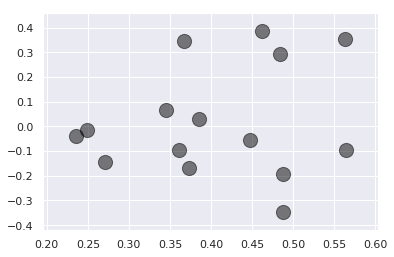

In [21]:
true_k = 15
labels = [i for i in range(true_k)]

vectorizer = tfidf_vectorizer
# Test K-means clustering for LSA-reduced TF-IDF vectorized features (no NMR or LDA)
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,verbose=False)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(lsa_tfidf_vectorized_features)
print("done in %0.3fs" % (time() - t0))
print()

print("Top terms per cluster:")

if n_components:
    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
else:
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [36]:
k_size = [1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150]
vectorizer = tfidf_vectorizer
inertias = []

for i in range(len(k_size)):
    km = KMeans(n_clusters=k_size[i], init='k-means++', max_iter=100, n_init=1,verbose=False)
    km.fit(lsa_tfidf_vectorized_features)
    inertias.append(km.inertia_)

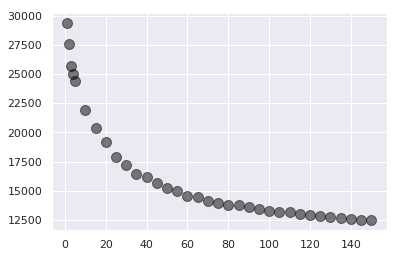

In [37]:
plt.scatter(k_size, inertias, c='black', s=100, alpha=0.5);